In [1]:
# this cell makes it easier to mess with the project code interactively
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import logging
import numpy
import pandas
import pathlib
import matplotlib
from matplotlib import pyplot, cm

import arviz
import pymc3

_log = logging.getLogger('notebook')
logging.basicConfig(level=logging.INFO)

# messing with the path to get imports working
import sys
sys.path.append(str(pathlib.Path("..").resolve()))

import rtlive
from rtlive import data, preprocessing

ERROR:fbprophet.plot:Importing plotly failed. Interactive plots will not work.


In [3]:
from rtlive.sources import ourworldindata, data_de, data_be

In [4]:
run_time = pandas.Timestamp.today()
owid_data = ourworldindata.download_owid(run_time)
data_be_data = data_be.get_data_BE(run_time)

E:\Anaconda3\envs\rtlive\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'epistat.sciensano.be'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


In [5]:
df_be = data_be_data.copy()
df_owid_be = owid_data.xs('BE')
df_owid_be_total_tests = df_owid_be.xs('all').total_tests
df_owid_be_daily_tests = df_owid_be_total_tests.diff()

## Attempt to create the DataFrame as it would be created by the data_de source

In [6]:
#Create weekly data with NaN gaps as total_tests_reported column for the `all` region:
df_be_weekly_total_tests = df_owid_be_total_tests.resample('W-Sun', level='date').last() #XXX: I don't know if the german data reported for sunday does include the data for sunday itself.
df_be_weekly_total_tests.drop(df_be_weekly_total_tests.tail(1).index,inplace=True) #Remove last row, because its an incomplete week in the future
weekly_data_frame = df_be_weekly_total_tests.resample('1D').asfreq().rename('total_tests_reported').to_frame()
weekly_data_frame['region'] = 'all'
weekly_data_frame = weekly_data_frame.reset_index().set_index(['region', 'date'])

df_be_merged = df_be.assign(total_tests_reported=weekly_data_frame)
df_be_merged

new_cases  new_tests  total_tests_reported
region date                                                  
ANT    2020-03-01          0         18                   NaN
       2020-03-02          1         38                   NaN
       2020-03-03          1        112                   NaN
       2020-03-04          3        131                   NaN
       2020-03-05          9        118                   NaN
...                      ...        ...                   ...
all    2021-01-04       2032      40167                   NaN
       2021-01-05       3395      59610                   NaN
       2021-01-06       3281      54938                   NaN
       2021-01-07       2360      42288                   NaN
       2021-01-08         90       2071                   NaN

[4396 rows x 3 columns]

Simulate the current data situation for germany: Daily data until approx. 2020-12-07, weekly data until 2020-12-27

In [7]:
end_of_daily_data = pandas.Timestamp('2020-12-07')
end_of_weekly_data = pandas.Timestamp('2020-12-27') + pandas.Timedelta('1D')

In [8]:
df_be_merged.loc[('all', slice(end_of_daily_data,None)), 'new_tests'] = numpy.nan
df_be_merged.loc[('all', slice(end_of_weekly_data,None)), 'total_tests_reported'] = numpy.nan

## Call the original forecast method

In [9]:
df_forecast, results = data_be.forecast_BE(df_be_merged) #Using DE forecast, because BE didn't work?

INFO:E:\Projects\rtlive-global\rtlive\preprocessing.py:Forecasting testcount gaps for ANT from 314 training points.
INFO:E:\Projects\rtlive-global\rtlive\preprocessing.py:Forecasting testcount gaps for WBR from 314 training points.
INFO:E:\Projects\rtlive-global\rtlive\preprocessing.py:Forecasting testcount gaps for BRU from 314 training points.
INFO:E:\Projects\rtlive-global\rtlive\preprocessing.py:Forecasting testcount gaps for FLA from 314 training points.
INFO:E:\Projects\rtlive-global\rtlive\preprocessing.py:Forecasting testcount gaps for HAI from 314 training points.
INFO:E:\Projects\rtlive-global\rtlive\preprocessing.py:Forecasting testcount gaps for LIM from 314 training points.
INFO:E:\Projects\rtlive-global\rtlive\preprocessing.py:Forecasting testcount gaps for LIE from 314 training points.
INFO:E:\Projects\rtlive-global\rtlive\preprocessing.py:Forecasting testcount gaps for LUX from 314 training points.
INFO:E:\Projects\rtlive-global\rtlive\preprocessing.py:Forecasting testc

(18589.0, 18650.65)

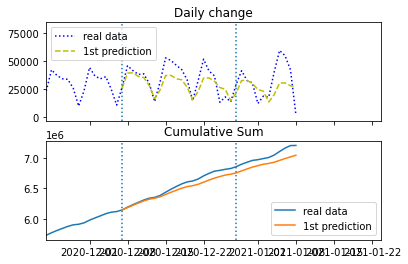

In [10]:
plotstart = end_of_daily_data - pandas.Timedelta('2W')
fig, axs = pyplot.subplots(2,sharex=True)
axs[0].axvline(end_of_daily_data,linestyle="dotted")
axs[0].axvline(end_of_weekly_data,linestyle="dotted")
axs[0].set_title("Daily change")
axs[0].plot(data_be_data.loc['all']['new_tests'], 'b:', label="real data")
axs[0].plot(df_forecast.loc['all']['predicted_new_tests'][end_of_daily_data:], "y--",  label = "1st prediction")
axs[0].legend()
axs[1].set_title("Cumulative Sum")
axs[1].axvline(end_of_daily_data,linestyle="dotted")
axs[1].axvline(end_of_weekly_data,linestyle="dotted")
axs[1].plot(data_be_data.loc['all']['new_tests'].cumsum()[plotstart:],label="real data")
axs[1].plot(df_forecast.loc['all']['predicted_new_tests'].cumsum()[end_of_daily_data:], label = "1st prediction")
axs[1].legend()
pyplot.xlim(plotstart)

## Call scaling method of `data_de` source

In [11]:
corrected_prediction = data_de.scale_forecast_by_total_tests_reported(df_forecast.loc['all', 'new_tests'], df_forecast.loc['all', 'total_tests_reported'], df_forecast.loc['all', 'predicted_new_tests'])

(18589.0, 18650.65)

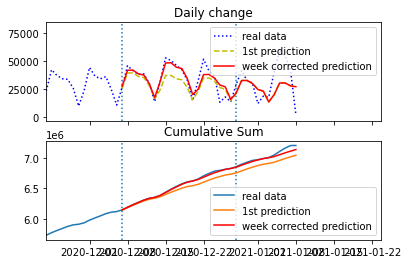

In [12]:
fig, axs = pyplot.subplots(2,sharex=True)
axs[0].axvline(end_of_daily_data,linestyle="dotted")
axs[0].axvline(end_of_weekly_data,linestyle="dotted")
axs[0].set_title("Daily change")
axs[0].plot(data_be_data.loc['all']['new_tests'], 'b:', label="real data")
axs[0].plot(df_forecast.loc['all']['predicted_new_tests'][end_of_daily_data:], "y--",  label = "1st prediction")
axs[0].plot(corrected_prediction[end_of_daily_data:], "r-", label="week corrected prediction")
axs[0].legend()
axs[1].set_title("Cumulative Sum")
axs[1].axvline(end_of_daily_data,linestyle="dotted")
axs[1].axvline(end_of_weekly_data,linestyle="dotted")
axs[1].plot(data_be_data.loc['all']['new_tests'].cumsum()[plotstart:],label="real data")
axs[1].plot(df_forecast.loc['all']['predicted_new_tests'].cumsum()[end_of_daily_data:], label = "1st prediction")
axs[1].plot(corrected_prediction.cumsum()[end_of_daily_data:], "r-", label="week corrected prediction")
axs[1].legend()
pyplot.xlim(plotstart)

## Overwrite predicted test result

In [13]:
df_forecast.loc['all', 'predicted_new_tests'] = corrected_prediction